In [1]:
from dl_portfolio.logger import LOGGER
import os, logging
import sys

from dl_portfolio.run import run_ae, run_kmeans, run_nmf
from dl_portfolio.data import load_data, get_features
from dl_portfolio.pca_ae import get_layer_by_name, heat_map, build_model
from dl_portfolio.train import build_model_input
import matplotlib.pyplot as plt

import numpy as np
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
SAVE = False
run_path = "final_models/ae/dataset1/m_0_seed_6_1682872204041201"
SAVE_DIR = "paper_result_update/ae"
cv = 68

In [3]:
if not os.path.isdir(SAVE_DIR):
    print(f"Created dir {SAVE_DIR}")
    os.mkdir(SAVE_DIR)
sys.path.append(run_path)
import ae_config as config

data, assets = load_data(dataset=config.dataset)
input_dim = data.shape[-1]
seed = 0


if config.encoding_dim is None:
    embedding = pd.read_pickle(f"{base_dir}/{cv}/encoder_weights.p")
    encoding_dim = embedding.shape[-1]
    # Set encoding_dim of kernel_regularizer
else:
    encoding_dim = config.encoding_dim

kernel_regularizer = config.kernel_regularizer
kernel_regularizer.encoding_dim = encoding_dim

if config.scaler_func is not None:
    scaler_method = config.scaler_func["name"]
    scaler_params = config.scaler_func.get("params", {})
else:
    scaler_method = None
    scaler_params = {}

train_data, val_data, test_data, scaler, dates = get_features(
    data,
    config.data_specs[cv]["start"],
    config.data_specs[cv]["end"],
    assets,
    val_start=config.data_specs[cv]["val_start"],
    test_start=config.data_specs[cv].get("test_start"),
    scaler=scaler_method,
    excess_ret=config.excess_ret,
    **scaler_params,
)

relu_model, relu_encoder, extra_features = build_model(
    config.model_type,
    input_dim,
    encoding_dim,
    n_features=None,
    extra_features_dim=1,
    activation="relu",
    batch_normalization=config.batch_normalization,
    kernel_initializer=config.kernel_initializer,
    kernel_constraint=config.kernel_constraint,
    kernel_regularizer=kernel_regularizer,
    activity_regularizer=config.activity_regularizer,
    loss=config.loss,
    uncorrelated_features=config.uncorrelated_features,
    weightage=config.weightage,
    encoder_bias=config.encoder_bias,
    decoder_bias=config.decoder_bias,
)
relu_model.load_weights(f"{run_path}/{cv}/model.h5")

train_prediction = scaler.inverse_transform(relu_model.predict(train_data))
train_prediction = pd.DataFrame(train_prediction, 
                                index=dates["train"], columns=assets)
train_data = pd.DataFrame(scaler.inverse_transform(train_data),
                          index=dates["train"], columns=assets)


gamma = relu_model.layers[2].gamma.numpy()
moving_mean = relu_model.layers[2].moving_mean.numpy()
moving_var = relu_model.layers[2].moving_variance.numpy()
beta = relu_model.layers[2].beta.numpy()
epsilon = relu_model.layers[2].epsilon
factor_cutoff = (gamma  * (- moving_mean) / np.sqrt(moving_var + epsilon) + beta)

decoding = relu_model.layers[-1].get_weights()[0]
bias = relu_model.layers[-1].get_weights()[-1]
asset_cutoff = np.dot(decoding.T, factor_cutoff) + bias
asset_cutoff *= scaler.scale_
asset_cutoff += scaler.mean_
asset_cutoff = pd.Series(asset_cutoff, index=assets)

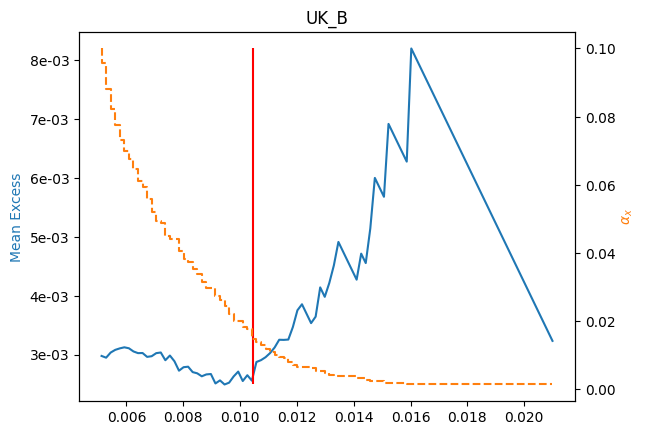

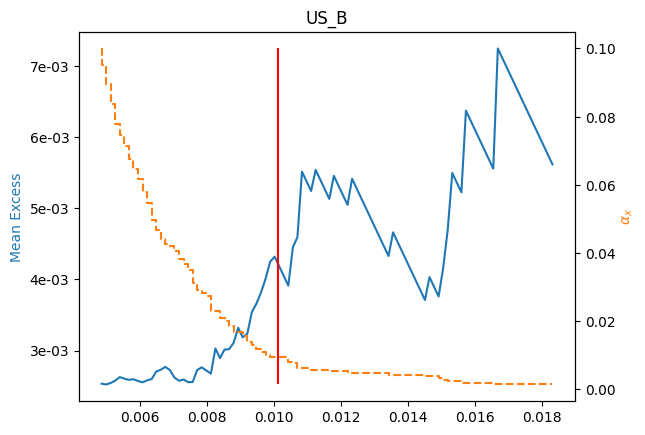

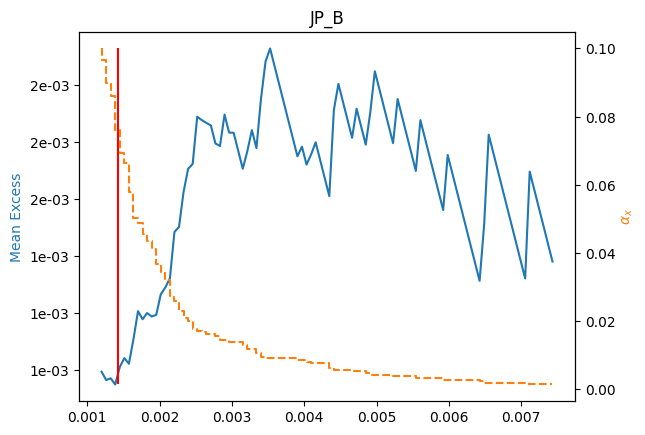

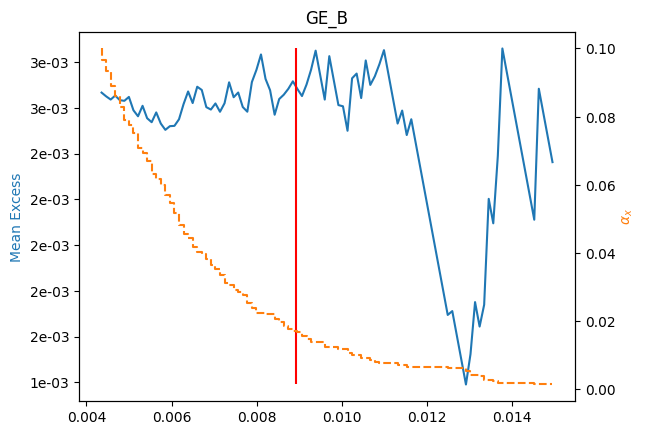

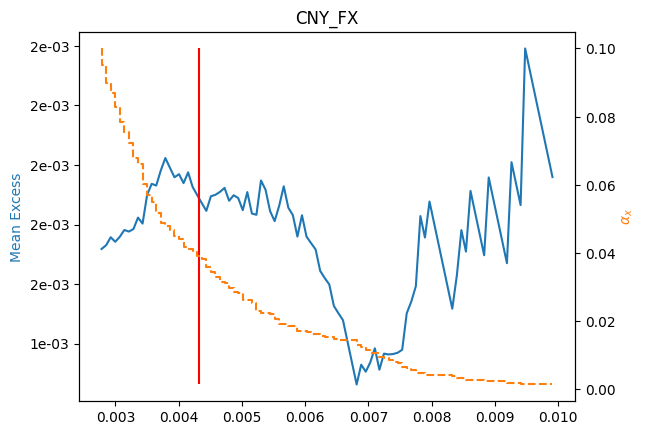

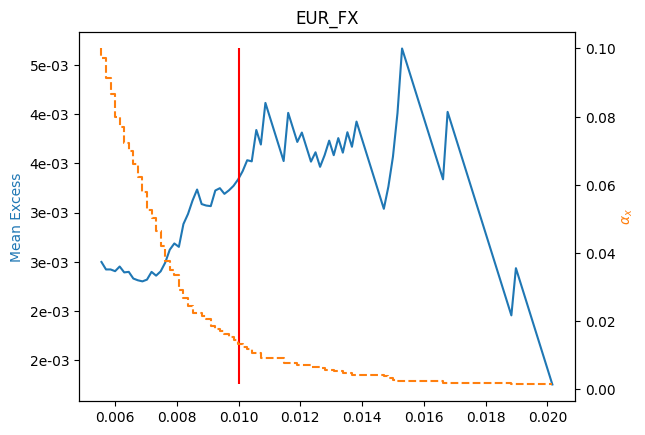

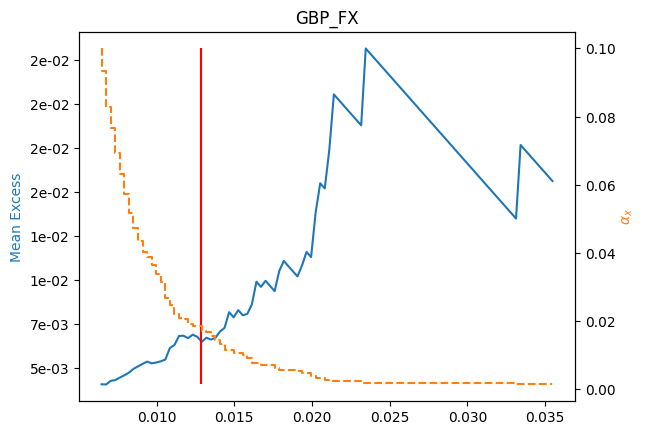

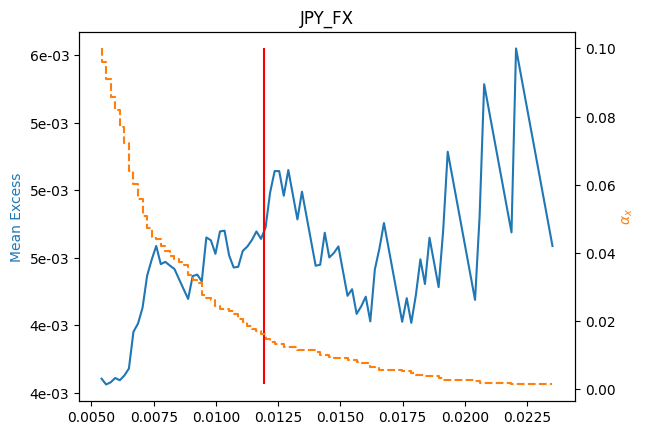

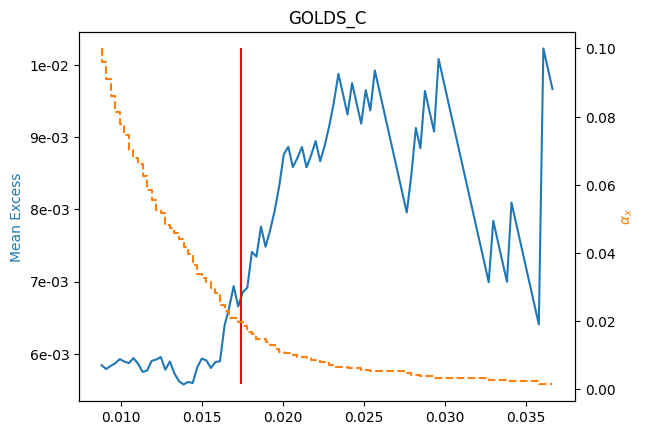

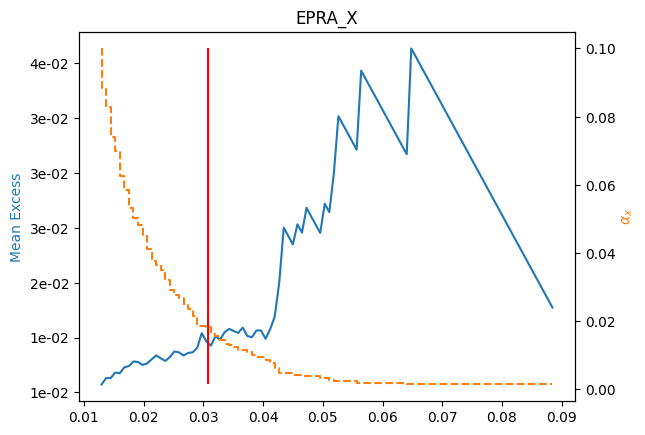

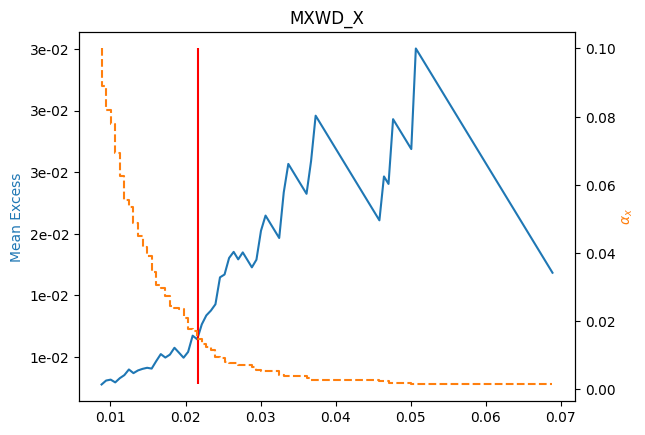

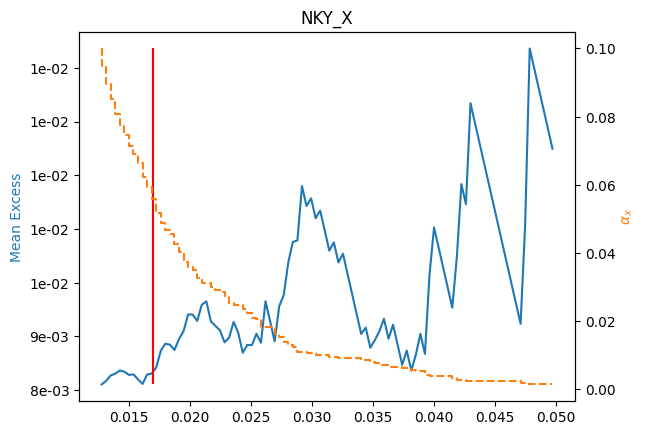

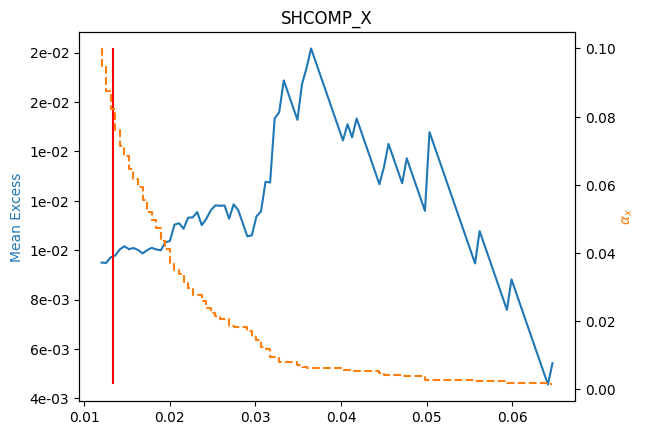

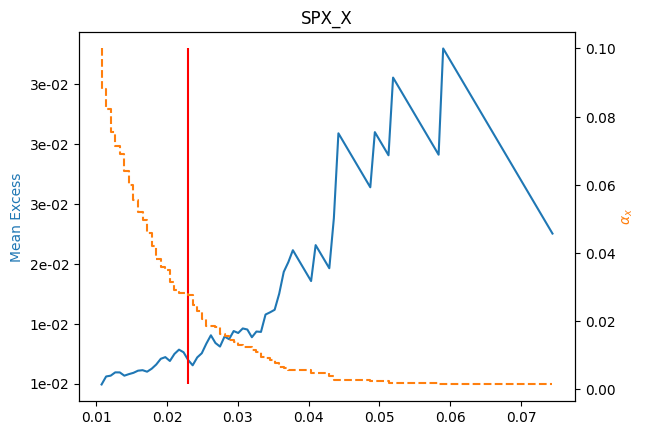

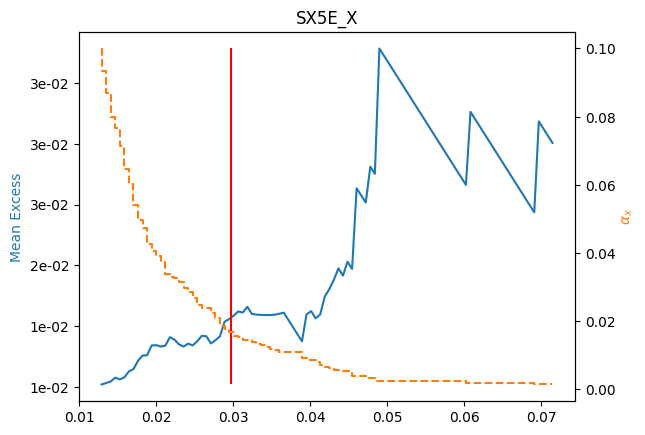

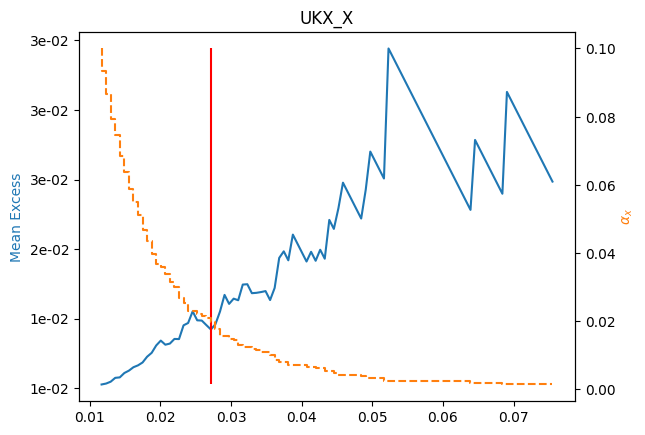

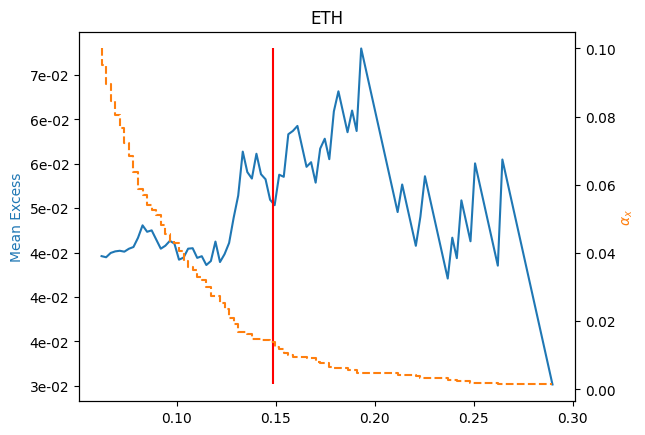

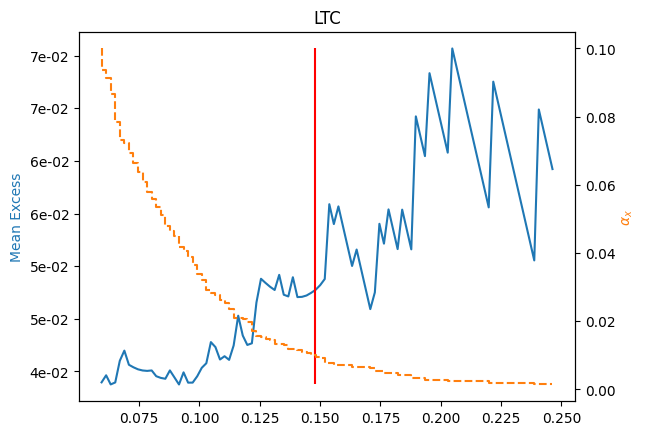

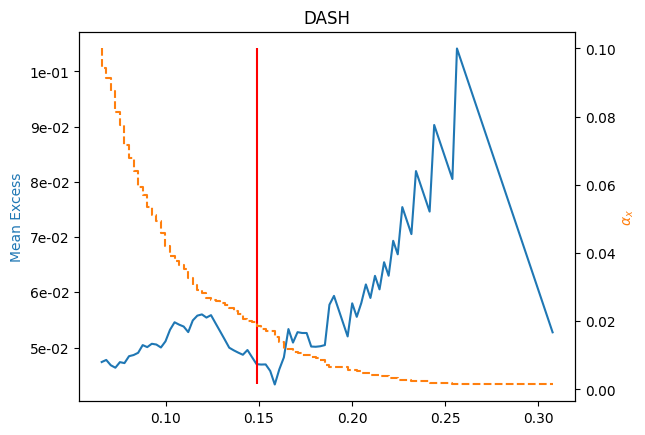

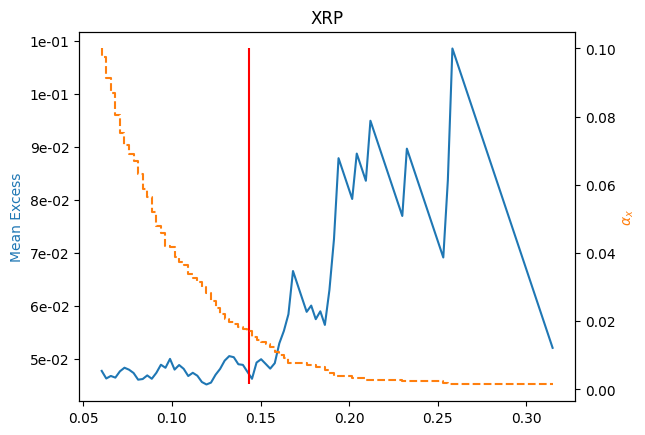

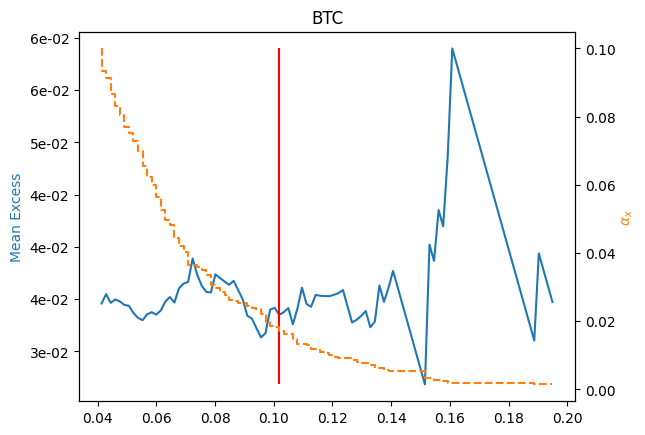

In [7]:
save=SAVE
from matplotlib.ticker import FormatStrFormatter
for a in assets:
    temp = -train_data[a]
    min_u = np.quantile(temp, 0.9)
    max_u = np.quantile(temp, 0.999)

    x = np.linspace(min_u, max_u, 100)
    y1 = [np.mean(temp[temp >= u] - u) for u in x]
    y2 = [np.sum(temp >= u)/len(temp) for u in x]

    fig, ax1 = plt.subplots()

    ax1.plot(x, y1)
    ax1.vlines(-asset_cutoff[a], min(y1), max(y1), color="red")
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.e"))
    ax1.set_ylabel('Mean Excess', c="tab:blue")

    ax2 = ax1.twinx()
    ax2.step(x, y2, '--', c="tab:orange")
    ax2.set_ylabel('$\\alpha_x$', c="tab:orange")
    if save:
        plt.savefig(f"{SAVE_DIR}/mean_excess_{a}.png",
                    transparent=True, bbox_inches="tight")
    plt.title(a)
    plt.show()